In [2]:
import numpy as np
import  numpy.fft as fft
import xarray as xr
from model_me5311 import DataProcessor

/home/crslab/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Load Data #
Please download the data files `slp.nc` and `t2m.nc` to the current directory before running this notebook. 

In [3]:
# dimensions of data
B = 16071
H = 101 
W = 161
split_idx = 15342 # 2021-01-01

t_scale = 4 / (365*4 + 1)
yr_start = 1979

# load data
ds_slp = xr.open_dataset('data/slp.nc')["msl"] 
ds_t2m = xr.open_dataset('data/t2m.nc')["t2m"]
ds_slp = np.array(ds_slp)
ds_t2m = np.array(ds_t2m)

# split into train and test set
slp_train, slp_test = ds_slp[:split_idx], ds_slp[split_idx:]
t2m_train, t2m_test = ds_t2m[:split_idx], ds_t2m[split_idx:]
del ds_slp, ds_t2m

# rescale the date such that each unit represents a whole year
time_arr = np.arange(B) * t_scale
t_train, t_test = time_arr[:split_idx], time_arr[split_idx:]



# Select data to analyze #
In this notebook, the data are analyzed separately. 

Please select the data to run in this section. 

In [4]:
train_data = slp_train.reshape(-1, H*W)
test_data = slp_test.reshape(-1, H*W)
threshold = 1.5e7
unit = "Pa"

train_data = t2m_train.reshape(-1, H*W)
test_data = t2m_test.reshape(-1, H*W)
threshold = 6e4
unit = "℃"

# PCA Analysis #
Analyze the training data with pca

In [5]:
model = DataProcessor()
modes = model.apply_pca(t_train, train_data.reshape(-1, H*W), 
              n_components=10
              )

# Visualize the dominant modes #

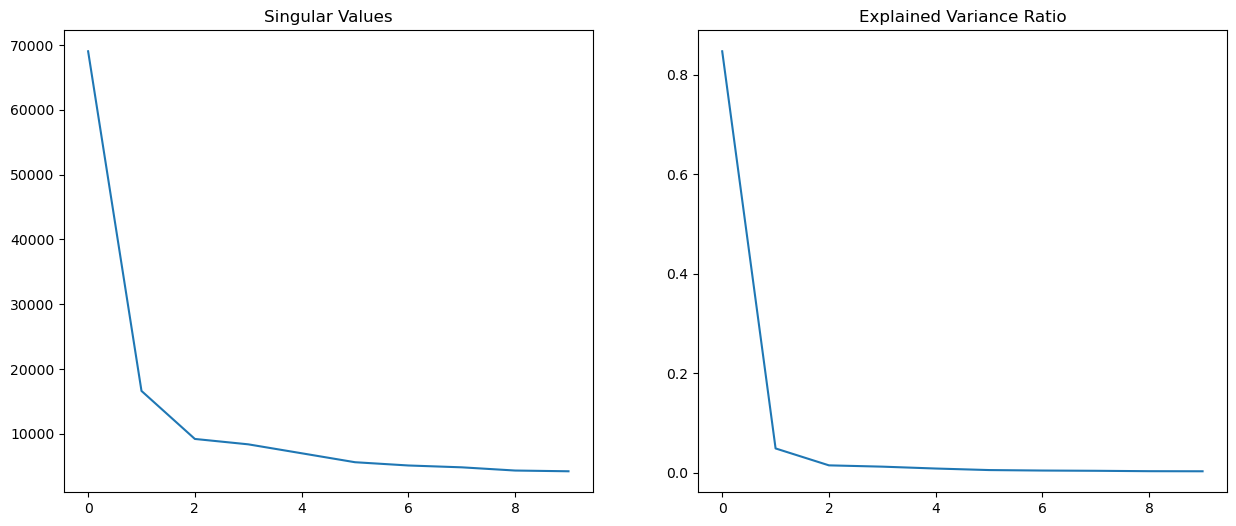

<Figure size 640x480 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='idx', max=9.0, step=1.0), Output()), _dom_classes=('…

<function __main__.<lambda>(idx)>

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

idx = 0
cmap = "RdBu" # "inferno"

# Update function for slider
def update(idx, img):
    idx = int(idx)
    img_mod = plt.imshow(img[idx], cmap=cmap, vmin=-0.03, vmax=0.03)
    plt.colorbar(img_mod)
    plt.title(f"Dominant Mode {int(idx+1)}")


# plot the singular values and energy of each mode
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3*2)) 
axes[0].plot(model.pca_model.singular_values_)
axes[0].title.set_text("Singular Values")
axes[1].plot(model.pca_model.explained_variance_ratio_)
axes[1].title.set_text("Explained Variance Ratio")


# visualize the dominant modes
plt.figure()
modes_vec = model.pca_model.components_.reshape(-1, H, W)
interact(lambda idx: update(idx, modes_vec), idx=FloatSlider(value=0,min=0,max=model.n_components-1,step=1))

# Plot the change of mode over time #

In [7]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

idx = 0

# Update function for slider
def update(idx, t, val):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3*2)) 
    axes[0].plot(t + yr_start, val[:, int(idx)])
    axes[0].title.set_text(f"Change of mode {int(idx+1)} over time")
    axes[0].set_xlabel("Year")

    freq = fft.fft(val[:, int(idx)])
    axes[1].plot(np.abs(freq[:1000]))
    axes[1].title.set_text(f"Frequency components of mode {int(idx+1)}")

plt.show()

interact(lambda idx: update(idx, t_train, modes), idx=FloatSlider(value=0,min=0,max=model.n_components-1,step=1))

interactive(children=(FloatSlider(value=0.0, description='idx', max=9.0, step=1.0), Output()), _dom_classes=('…

<function __main__.<lambda>(idx)>

# Data Processing #
Use the customized model to extract and filter the first 10 dominant modes

In [8]:
n_components = 10
modes_filtered = model.fit(t_train, train_data, 
                           n_components=n_components, 
                           threshold=threshold, 
                           normalize=True
                           )

In [9]:
modes_train_pred = model.pred_modes(t_train)


In [10]:
# for test only, neglect this cell

num = 0
print(modes_train_pred.shape, modes_filtered.shape)
err = modes_train_pred[:-1] - modes_filtered[:-1]


# plt.plot(modes_train_pred[:, num])
# plt.plot(modes_filtered[:, num])
# # plt.plot(np.linalg.norm(err, axis=1), c='r')
# plt.plot(err[:, num], c='r')
plt.plot(np.linalg.norm(err, axis=1))


(15342, 10) (15342, 10)


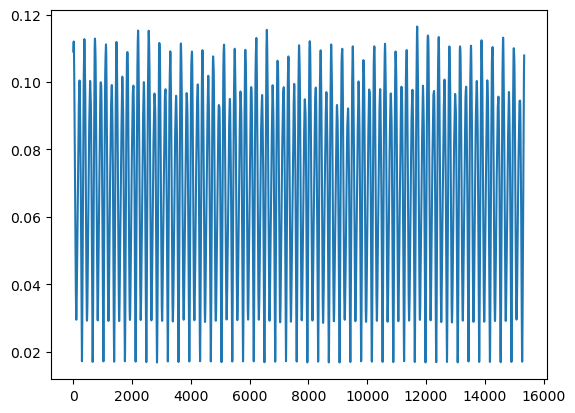

interactive(children=(FloatSlider(value=0.0, description='idx', max=9.0, step=1.0), Output()), _dom_classes=('…

<function __main__.<lambda>(idx)>

In [11]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

idx = 0

# Update function for slider
def update(idx, t, val):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3*2)) 
    axes[0].plot(t, val[:, int(idx)])
    axes[0].title.set_text(f"Change of mode {int(idx+1)} over time")
    axes[0].set_xlabel("Year")

    freq = fft.fft(val[:, int(idx)])
    axes[1].plot(np.abs(freq[:1000]))
    axes[1].title.set_text(f"Frequency components of mode {int(idx+1)}")

plt.show()

interact(lambda idx: update(idx, t_train, modes_filtered), idx=FloatSlider(value=0,min=0,max=n_components-1,step=1))

# Predict Future Data #
Predict the evolution of modes for the test data.

In [12]:
modes_test_pred = model.pred_modes(t_test)
modes_train_pred = model.pred_modes(t_train)

In [13]:
k = 1000

# Update function for slider
def update(idx):
    plt.plot(t_train[-k:] + yr_start, modes_filtered[-k:, int(idx)])
    plt.plot(t_test[:k] + yr_start, modes_test_pred[:k, int(idx)])
    # plt.plot(t_train[-k:] + yr_start, modes_train_pred[-k:, int(idx)], c='r')


plt.show()

interact(lambda idx: update(idx), idx=FloatSlider(value=0,min=0,max=n_components-1,step=1))


interactive(children=(FloatSlider(value=0.0, description='idx', max=9.0, step=1.0), Output()), _dom_classes=('…

<function __main__.<lambda>(idx)>

# Model Evaluation #
Evaluate the model's prediction error. Note that 

1. To better evaluate the accuracy of the model, we compare its performance with a simple baseline approach, which naively outputs the training data's mean value all the time.  

2. To evaluate whether the prediction error would propagate over time, the trand of error change is also recorded

Mean error:  1.1099101975928263
Max error:  19.454059069401012
growth rate:  -0.058730074909790916


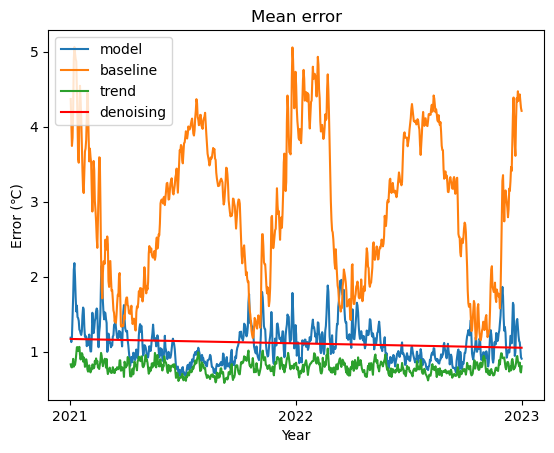

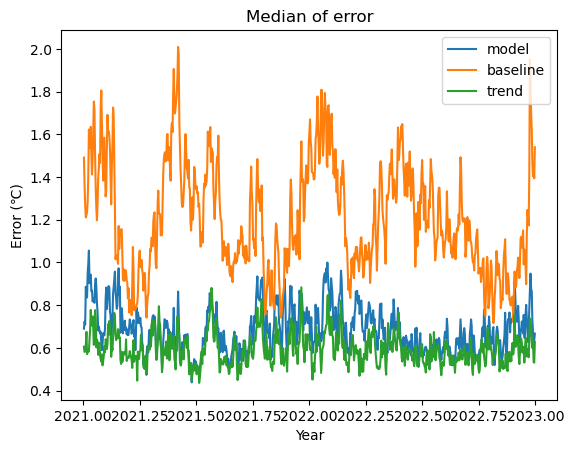

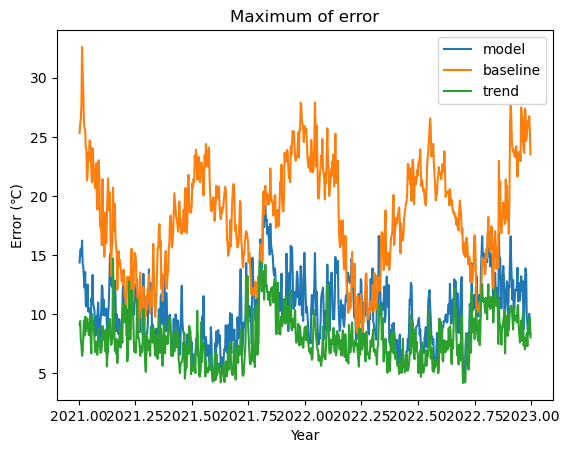

In [14]:
from matplotlib.ticker import MaxNLocator

baseline_est = np.mean(train_data, axis=0)
err_baseline = np.abs(baseline_est - test_data)
err_baseline_mean = err_baseline.mean(axis=1)
err_baseline_median = np.median(err_baseline, axis=1)
err_baseline_max = err_baseline.max(axis=1)

test_pred = model.inversePCA(t_test, modes_test_pred).reshape(-1, H, W)
err = np.abs(test_pred - test_data.reshape(-1, H, W))
err_mean = np.mean(err, axis=(1,2))
err_median = np.median(err, axis=(1,2))
err_max = np.max(err, axis=(1, 2))
print("Mean error: ", err.mean())
print("Max error: ", err.max())
w, b = np.polyfit(t_test, err_mean, 1)
print("growth rate: ", w)


test_pca = model.pca_model.transform(test_data.reshape(-1, H*W))
test_denoised = model.pca_model.inverse_transform(test_pca) # denoise the test data with pca
err_denoising = np.abs(test_denoised - test_data)
err_denoising_mean = np.mean(err_denoising, axis=1)
err_denoising_median = np.median(err_denoising, axis=(1,))
err_denoising_max = np.max(err_denoising, axis=(1, ))



ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(t_test+yr_start, err_mean)
plt.plot(t_test+yr_start, err_baseline_mean)
plt.plot(t_test+yr_start, err_denoising_mean)
plt.plot(t_test+yr_start, w * t_test + b, c='r')
# plt.plot(t_test+yr_start, np.mean(np.abs(test_pred - baseline_est.reshape(-1, H, W)),axis=(1,2)))
plt.xlabel("Year")
plt.ylabel(f"Error ({unit})")
plt.legend(["model", "baseline", "trend", "denoising"])
plt.title("Mean error")

plt.figure()
plt.plot(t_test+yr_start, err_median)
plt.plot(t_test+yr_start, err_baseline_median)
plt.plot(t_test+yr_start, err_denoising_median)
plt.xlabel("Year")
plt.ylabel(f"Error ({unit})")
plt.legend(["model", "baseline", "trend", "denoising"])
plt.title("Median of error")

plt.figure()
plt.plot(t_test+yr_start, err_max)
plt.plot(t_test+yr_start, err_baseline_max)
plt.plot(t_test+yr_start, err_denoising_max)
plt.xlabel("Year")
plt.ylabel(f"Error ({unit})")
plt.legend(["model", "baseline", "trend", "denoising"])
plt.title("Maximum of error")
plt.show()

In [15]:
i = 0
# plt.plot(t_test+yr_start, test_pca[:, i])
# plt.plot(t_test+yr_start, modes_test_pred[:, i])
plt.plot(test_pca[:, i] - modes_test_pred[:, i])


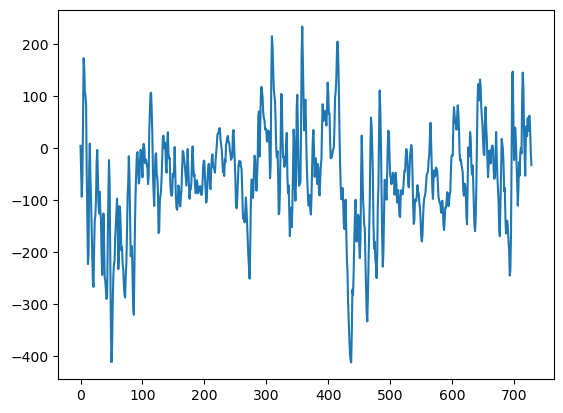

<Figure size 640x480 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='idx', max=9.0, step=1.0), Output()), _dom_classes=('…

<function __main__.<lambda>(idx)>

In [16]:
# Update function for slider
img_err = test_pred - test_data.reshape(-1, H, W)
def update(idx, img):
    idx = int(idx)
    img = plt.imshow(img_err[idx], cmap=cmap)
    plt.colorbar(img)

# visualize the dominant modes
plt.figure()
interact(lambda idx: update(idx, modes_vec), idx=FloatSlider(value=0,min=0,max=model.n_components-1,step=1))

In [17]:
# for test only

# train_predd = model.inversePCA(t_train, modes_train_pred)
# errr = np.abs(train_predd - train_data)
# plt.plot(np.mean(errr-train_predd,axis=1))
# print(train_predd[:5, 100])
# print(train_data[:5, 100])
# unit


xx = np.ones([5, 10])*1000
a = model.inversePCA(t_train[:5], xx)

xx[:, 5:]= 0
b = model.inversePCA(t_train[:5], xx)

# model.w


# print(np.isclose(a,b))
# print(not np.any(a-b))

# Error of modes # 

In [18]:
modes_test = model.pca_model.transform(test_data)
# err_modes_test = np.linalg.norm(modes_test - modes_test_pred, axis=1)
err_modes_test = np.abs(modes_test - modes_test_pred).mean(axis=1)

# modes_train = model.pca_model.transform(train_data)
# err_modes_train = np.linalg.norm(modes_train, axis=1)


plt.figure()
plt.plot(t_test+yr_start, err_modes_test)
# plt.plot(t_train+yr_start, err_modes_train)
plt.xlabel("Year")
plt.ylabel(f"Error of modes")
plt.title("Error of modes")

Text(0.5, 1.0, 'Error of modes')

In [19]:
# vmax = np.percentile(err, 90)
np.percentile(err[10], 90), np.max(err[10])

(4.1186804903854295, 10.698575888402104)

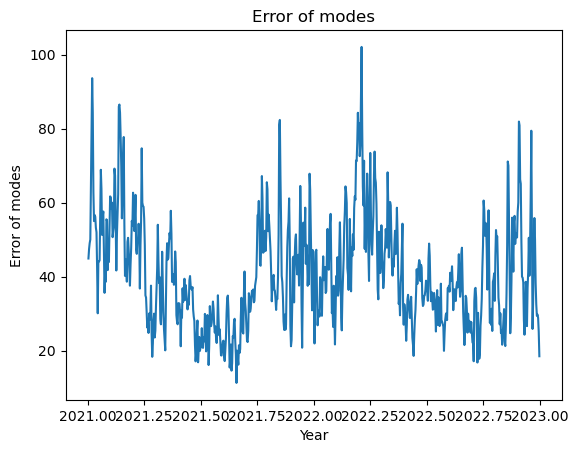

interactive(children=(FloatSlider(value=0.0, description='idx', max=728.0, step=1.0), Output()), _dom_classes=…

<function __main__.<lambda>(idx)>

In [20]:
err_img = test_pred - test_data.reshape(-1, H, W)
vmax = np.percentile(err, 95)
vmin = np.percentile(err, 95)

def update(idx):
    plt.imshow(err_img[int(idx)].reshape(H, W), cmap=cmap+"_r", vmin=0, vmax=vmax)
    plt.colorbar()

plt.show()

interact(lambda idx: update(idx), idx=FloatSlider(value=0,min=0,max=err.shape[0]-1,step=1))

# Impact of n_components on prediction error  #

In [21]:
# save the data!!!
# raise RuntimeError("save the data!")
train_pred = model.inversePCA(t_train, modes_train_pred).reshape(-1, H, W)
train_err = -(train_pred - train_data.reshape(-1, H, W))
test_err = -(test_pred - test_data.reshape(-1, H, W))

np.save("train_err.npy", train_err)
np.save("test_err.npy", test_err)
np.save("train.npy", train_data.reshape(-1, H, W))
np.save("test.npy", test_data.reshape(-1, H, W))


In [22]:
# np.save("train.npy", train_data.reshape(-1, H, W))
# np.save("test.npy", test_data.reshape(-1, H, W))
print(train_err.max())
print(np.percentile(train_err, 95))
print(np.percentile(train_err, 90))
print(np.percentile(train_err, 10))
print(np.percentile(train_err, 5))
print(train_err.min())


18.828859282522473
2.5010844100824974
1.5181621376585044
-1.4804098247413207
-2.569124667671639
-22.790578714557455


In [35]:
from unet import SSM5311
import torch
from dataset import SLP_ERR_SCALE, T2M_ERR_SCALE
from tqdm.notebook import tqdm
from utils import *
from config import *

part_name = "slp_vae_16_0.2826.pth"  if unit == "Pa" else  "t2m_vae_33_0.2875.pth" 
model_params = "model_selected/" + part_name  # "slp_model_36_0.1.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scale = SLP_ERR_SCALE if unit == "Pa" else T2M_ERR_SCALE

model = SSM5311(down_channels=global_down_chnl).to(device)
model.load_state_dict(torch.load(model_params))
model.eval()
scale

torch.Size([1, 2, 5, 5])


1.5

In [36]:
t_lookback = 10 
t_lookforward = 1
# test_data_tensor = test_data.reshape(-1, H, W) / scale
test_err = -(test_pred - test_data.reshape(-1, H, W)) / scale
test_data_tensor = torch.Tensor(test_err).to(device)

test_sample_num = (len(test_data) - t_lookback + t_lookforward - 1)
model_output = np.zeros([test_sample_num, H, W])

with torch.no_grad():
    for i in tqdm(range(test_sample_num)):
        x = test_data_tensor[i:i+t_lookback].unsqueeze(0)
        x = reshape_to_square(x)
        for j in range(t_lookforward):
            y = model(x)
            x[:, :-1] = x[:, 1:].clone()
            x[:, -1] = y[:, -1, ...].clone()
        y = reshape_back(y)[0, -1].cpu().numpy()
        model_output[i] = y * scale
model_output = np.array(model_output) # start from t_lookback: if t_lookback=20, then pred start from idx 20
model_output.shape



(719, 101, 161)

original avg error:  1.102813673446527
baseline error:  0.7402905760779213
new error:  0.9164394019029994


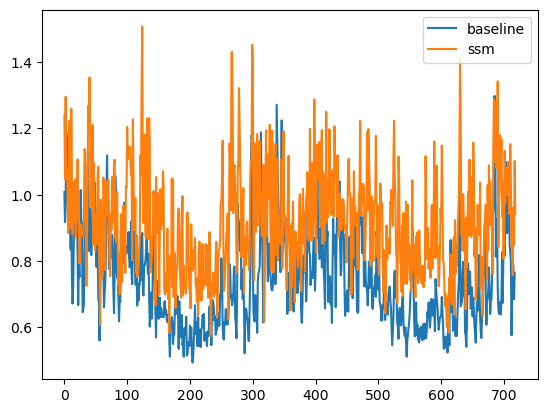

In [37]:
err_pca = -(test_pred - test_data.reshape(-1,H, W))[t_lookback: ]
# print(test_pred.max(), test_data.max(), err_pca.min())
print("original avg error: ", np.abs(err_pca).mean())

err_new = np.abs(err_pca - model_output)
err_baseline = np.abs(err_pca[1:] - err_pca[:-1])
print("baseline error: ", err_baseline.mean())
print("new error: ", err_new.mean())
plt.figure()
plt.plot(err_baseline.mean(axis=(-2, -1)))
plt.plot(err_new.mean(axis=(-2, -1)))
plt.legend(['baseline', 'ssm'])
plt.show()

In [32]:
err_pca = -(test_pred - test_data.reshape(-1,H, W))
def show_model_output(idx):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 3*3)) 
    im1 = axes[0,0].imshow(model_output[int(idx)].reshape(H, W), cmap=cmap+"_r", vmin=-scale, vmax=scale)
    # plt.colorbar(im1)

    # err_clipped = np.clip(err, -scale, scale)
    # im2 = axes[0,1].imshow(err_pca[int(idx)+t_lookback].reshape(H, W), cmap=cmap+"_r", vmin=-scale, vmax=scale)
    # im3 = axes[1,0].imshow(err_pca[int(idx)+t_lookback-1].reshape(H, W), cmap=cmap+"_r", vmin=-scale, vmax=scale)
    # im4 = axes[1,1].imshow(np.abs(err_pca[int(idx)+t_lookback] - model_output[int(idx)]).reshape(H, W), cmap=cmap+"_r", vmin=0, vmax=scale*1.5)
    
    im2 = axes[0,1].imshow(err_pca[int(idx)+t_lookback + t_lookforward-1].reshape(H, W), cmap=cmap+"_r", vmin=-scale, vmax=scale)
    im3 = axes[1,0].imshow(err_pca[int(idx)+t_lookback-1].reshape(H, W), cmap=cmap+"_r", vmin=-scale, vmax=scale)
    im4 = axes[1,1].imshow(np.abs(err_pca[int(idx)+t_lookback+t_lookforward-1] - model_output[int(idx)]).reshape(H, W), cmap=cmap+"_r", vmin=0, vmax=scale*1.5)
    plt.colorbar(im4)
    
    axes[0,0].set_title('pred')
    axes[0,1].set_title('ground truth')
    axes[1, 0].set_title('last frame')
    axes[1, 1].set_title('pred err')


# plt.show()


interact(lambda idx: show_model_output(idx), idx=FloatSlider(value=t_lookback,min=t_lookback, max=model_output.shape[0]-1,step=1))
# np.savez('ssm_slp.npz', pred=model_output, truth=err_pca)

interactive(children=(FloatSlider(value=10.0, description='idx', max=718.0, min=10.0, step=1.0), Output()), _d…

<function __main__.<lambda>(idx)>

In [27]:
raise RuntimeError("The program stops here! ")

RuntimeError: The program stops here! 

In [ ]:
from tqdm.notebook import tqdm

n_components_ = np.arange(1, 16)
err_mean_ = np.zeros_like(n_components_) * 0.0
err_median_ = np.zeros_like(n_components_) * 0.0
err_max_ = np.zeros_like(n_components_) * 0.0

for i, n in enumerate(tqdm(n_components_)):
   
    model_ = DataProcessor()
    model_.fit(t_train, train_data, 
                n_components=n, 
                threshold=threshold, 
                normalize=True
                )
    
    test_pred_ = model_.predict(t_test)
    err_ = np.abs(test_pred_ - test_data.reshape(-1,H*W))

    err_mean_[i] = err_.mean()
    err_median_[i] = np.median(err_)
    err_max_[i] = err_.max()

    # print(n, err.mean(), err.std())
    

plt.plot(n_components_, err_mean_)
plt.plot(n_components_, err_median_)
plt.plot(n_components_, err_max_, c="r")
plt.xlabel("n_components")
plt.ylabel(f"mean absolute error ({unit})")
plt.legend(["mean", "median", "max"])


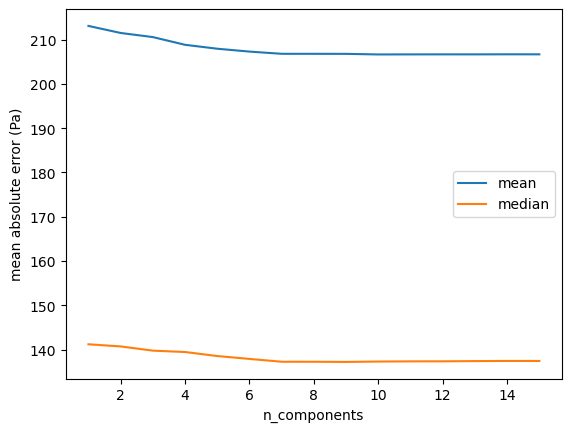

In [ ]:
plt.plot(n_components_, err_mean_)
plt.plot(n_components_, err_median_)

plt.xlabel("n_components")
plt.ylabel(f"mean absolute error ({unit})")
plt.legend(["mean", "median"])

In [ ]:
from tqdm.notebook import tqdm

threshold_ = np.arange(21)/10 * threshold
err_mean_ = np.zeros_like(threshold_) * 0.0
err_median_ = np.zeros_like(threshold_) * 0.0
err_max_ = np.zeros_like(threshold_) * 0.0

for i, th in enumerate(tqdm(threshold_)):
   
    model_ = DataProcessor()
    model_.fit(t_train, train_data, 
                n_components=n_components, 
                threshold=th, 
                normalize=True
                )
    
    test_pred_ = model_.predict(t_test)
    err_ = np.abs(test_pred_ - test_data.reshape(-1,H*W))

    err_mean_[i] = err_.mean()
    err_median_[i] = np.median(err_)
    err_max_[i] = err_.max()

    # print(n, err.mean(), err.std())
    

plt.plot(threshold_, err_mean_)
plt.plot(threshold_, err_median_)
plt.plot(threshold_, err_max_, c="r")
plt.xlabel("threshold")
plt.ylabel(f"mean absolute error ({unit})")
plt.legend(["mean", "median", "max"])


  0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 

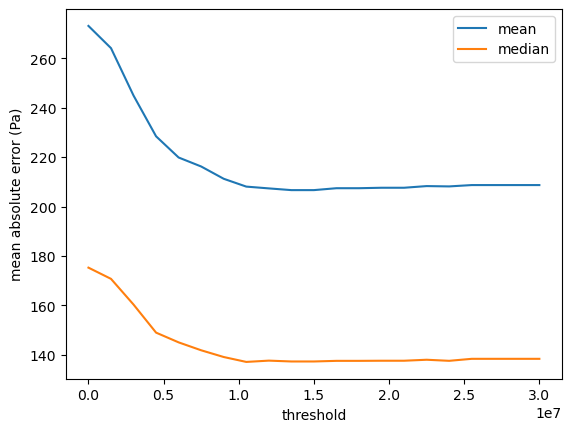

In [ ]:
plt.plot(threshold_, err_mean_)
plt.plot(threshold_, err_median_)
# plt.plot(threshold_, err_max_, c="r")
plt.xlabel("threshold")
plt.ylabel(f"mean absolute error ({unit})")
plt.legend(["mean", "median"])